<a href="https://colab.research.google.com/github/bbc/apprenticeship-covid-hack/blob/main/notebooks/EM_COVID_diagnosis_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 diagnosis using symptoms

[Prateek Gupta](https://www.pgupta.info) 

2020-05-20

**Abstract:** This notebook is a tutorial on building a typical machine learning classifier. 
The process of doing so spans steps ranging from data wrangling to model selection. 
With the help of each of these steps we hope to make the reader familiar with challenges involved in building a machine learning system. 

# Question

In this hackathon, we want to build a machine learning model to predict COVID-19 infections from symptoms.
It has several applications, for example, triaging patients to be attended to by a doctor or nurse, recommending self-isolation through contact tracing apps. 

Zoabi et al. [[1]](https://www.nature.com/articles/s41746-020-00372-6) builds a decision tree classifier using the publicly available data reported by the Israeli Ministry of Health.
The paper itself dicsusses the various challenges encountered in deploying such a model. 
It is encouraged to read the paper and learn the challeges and ways to overcome them. 

However, in this hackathon, we will use their dataset and make the participant familiar with a typical pipeline of building a machine learning system.

[1] [Zoabi, Y., Deri-Rozov, S. & Shomron, N. Machine learning-based prediction of COVID-19 diagnosis based on symptoms. npj Digit. Med. 4, 3 (2021).]((https://www.nature.com/articles/s41746-020-00372-6))


# Setup the workspace

We will clone their Git repository to to use their dataset

In [4]:
!git clone https://github.com/nshomron/covidpred.git

Cloning into 'covidpred'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 35 (delta 16), reused 10 (delta 3), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [121]:
import pandas as pd
import math
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Data 

Let's check how the data looks like and how various features are encoded. 

In [188]:
df = pd.read_csv('covidpred/data/corona_tested_individuals_ver_006.english.csv.zip')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df.columns

Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication'],
      dtype='object')

Great! These are the features used in the paper for their prediction task. The authors also list these features in the [README.md of their Github repo](https://github.com/nshomron/covidpred). 

Pandas read columns as string, so we need to convert them to the proper format before we can operate on it.

In [189]:
df['test_date'] = pd.to_datetime(df['test_date'])

In [190]:
print("Start date:", min(df['test_date']))
print("End date:", max(df['test_date']))

n_days = (max(df['test_date']) - min(df['test_date'])).days
print("# of days: ", n_days)

n_obs =  df.shape[0]
print("# of observations:", df.shape[0])
print("# of features:", df.shape[1])

pos_cases = sum(df['corona_result'] == "positive")
print("# of positively diagnosed cases: {0} ({1: 2.2f}%)".format(pos_cases, 100*pos_cases / n_obs))

neg_cases = sum(df['corona_result'] == "negative")
print("# of negatively diagnosed cases: {0} ({1: 2.2f}%)".format(neg_cases, 100 * neg_cases / n_obs))

other_cases = sum(df['corona_result'] == "other") # possibly not confirmed
print("# of other cases (possibly, not confirmed): {0} ({1: 2.2f}%)".format(other_cases, 100 * other_cases / n_obs))

Start date: 2020-03-11 00:00:00
End date: 2020-04-30 00:00:00
# of days:  50
# of observations: 278848
# of features: 10
# of positively diagnosed cases: 14729 ( 5.28%)
# of negatively diagnosed cases: 260227 ( 93.32%)
# of other cases (possibly, not confirmed): 3892 ( 1.40%)


Since we do not have any information on what happened to "other" cases, we will exclude them from our exercise. 



In [191]:
df = df[df['corona_result'].isin(['positive', 'negative'])]

To build out predictor, we will be splitting our dataset into **training,  validation, and test sets**. 
A model is trained on the training dataset while the hyperparameters are tuned on the validation dataset. 
Finally, a test dataset is used to report final model's performance metrics. 

Since we have a time dependent dataset we will split our training and test dataset based on time. 
Thus, we find the date before which 60% of observations are present, and use that as our training dataset.
We will use next 20% of the dataset as our validation dataset, and finally, the remaining 20% will be used as a test dataset. 
Thus, we use 60-20-20 split.

The authors use 63%-23% training-test split, and a further split of training into train-valid dataset using 80-20% split.
There is no prescribed formula on how to do this split. 



In [192]:
date_counts = df.groupby(['test_date']).count()['gender'] # take count of any column. They will all be same.
date_counts = date_counts.sort_index()
cum_counts = date_counts.cumsum()
cdf = cum_counts / n_obs


In [196]:
max_training_date = cdf[cdf < 0.60].index.max()
training_data_original = df[df['test_date'] <= max_training_date]

min_test_date = cdf[cdf > 0.80].index.min()
test_data_original = df[df['test_date'] >= min_test_date]

valid_data_original = df[(max_training_date < df['test_date']) & (df['test_date'] < min_test_date)]

print("# of observations in training dataset", training_data_original.shape[0])
print("# of observations in validation dataset", valid_data_original.shape[0])
print("# of observations in test dataset", test_data_original.shape[0])

# of observations in training dataset 160717
# of observations in validation dataset 53172
# of observations in test dataset 61067


In [197]:
# Data Cleaning
def normalise(x):
  if type(x) == str:
    return int(x) if x != "None" else 2
  return x

symptoms = ["cough","fever","sore_throat","shortness_of_breath","head_ache"]
categorical = ["age_60_and_above","gender","test_indication"]

#Clean inconsitent datatypes within symptom columns
for col in symptoms:
  df.loc[:, col] = df[col].apply(normalise)

X = df.drop("test_date",axis=1)
y = X["corona_result"]

#New split off training data and then split the remaining into validation and test
training_data, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
valid_data, test_data, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)


**NOTE:**
It is **extremely important** that you do not use the test dataset in the model building phase. 
While building models, it is required to tune the hyperparameter, adjust assumptions, modify features, etc. 
This should be done on the validation dataset. 
After several such iterations on the validation dataset, you will pick a model with the best performace as your final model. 

A test dataset is used to measure the final model's performance, which is a proxy for how it will perform (or generalize) in real life. 
Thus, to have a proper measure of model's genearalization, test dataset should not be part of your model building process. 

# Exploratory Data Analysis

In this section, we will see the general statistics of features.
In doing so, we will encounter inconsistencies in the data and address them accordingly. 







In [199]:
# We want to predict 'corona_result'. 
# We will not use "test_date" as a feature. 
# So we narrow down the input features to this list 
INPUT_FEATURES = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
TARGET_COLUMN = 'corona_result'

for col in INPUT_FEATURES:
  print("*"*25, f" {col} ", "*"*25)
  print(training_data_original[col].value_counts())

for col in INPUT_FEATURES:
  print("*"*25, f" {col} ", "*"*25)
  print(training_data[col].value_counts())

*************************  cough  *************************
0    131741
1     28724
2       252
Name: cough, dtype: int64
*************************  fever  *************************
0    145642
1     14823
2       252
Name: fever, dtype: int64
*************************  sore_throat  *************************
0    158847
1      1869
2         1
Name: sore_throat, dtype: int64
*************************  shortness_of_breath  *************************
0    159185
1      1531
2         1
Name: shortness_of_breath, dtype: int64
*************************  head_ache  *************************
0    158358
1      2358
2         1
Name: head_ache, dtype: int64
*************************  age_60_and_above  *************************
No      123867
Yes      25425
None     11425
Name: age_60_and_above, dtype: int64
*************************  gender  *************************
male      72598
female    70950
None      17169
Name: gender, dtype: int64
*************************  test_indication  *********

In [128]:
# EM
# training_data_original = training_data
# training_data_original.info()
# all objects overall, from above looks like a mix of categorical and integer.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163189 entries, 115659 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   test_date            163189 non-null  datetime64[ns]
 1   cough                163189 non-null  object        
 2   fever                163189 non-null  object        
 3   sore_throat          163189 non-null  object        
 4   shortness_of_breath  163189 non-null  object        
 5   head_ache            163189 non-null  object        
 6   corona_result        163189 non-null  object        
 7   age_60_and_above     163189 non-null  object        
 8   gender               163189 non-null  object        
 9   test_indication      163189 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 13.7+ MB


Here are the questions to guide you through the process of exploring data 

1.   Think about possible biases and limitations of this dataset
2.   What is the format of feature values? Are there any inconsistencies? If so, how would you make them cosistent?
3.   What is the statistics of these feature values? How many symptoms are reported or not?
4.   Which symptoms have a reporting bias, i.e., likely to be reported when the patient is COVID positive? 
5.   How will the symptoms with reporting bias affect the model’s performance?
6.   Visualization: Draw the bar graph of features grouped by the target class? 
7.   How does the bar graph of the symptoms with reporting bias looks like?
8.   Determine if we have a class imbalance in the dataset? If so, what do you reckon will be the downstream challenges in evaluating the model? How will you overcome those challenges?
9.   What does "None" value mean for feature? Should we include these features?

**Format of feature values**<br>
Integer columns - some seem to be a mix of character and integer, we should make them all integer (1/0). <br>
Character columns - age 60 and above (yes/no) can be transformed as dummy variables. <br>



In [66]:
# For symptom aka integer columns - drop 'None' observations, convert column to integer
# integers = ["cough", "fever", "sore_throat", "shortness_of_breath", "head_ache"]


# for col in integers:
#     training_data = training_data[training_data[col] != "None"]
#     training_data[col] = training_data[col].astype(int)
#     print(training_data[col].value_counts())

# print("Original obs = 160717, number of observations now removed data:", training_data.shape)

# training_data.info()
# # sorted the integer columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


0    131741
1     28724
Name: cough, dtype: int64
0    145641
1     14822
Name: fever, dtype: int64
0    158598
1      1865
Name: sore_throat, dtype: int64
0    158935
1      1528
Name: shortness_of_breath, dtype: int64
0    158111
1      2352
Name: head_ache, dtype: int64
Original obs = 160717, number of observations now removed data: (160463, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 160463 entries, 115659 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   test_date            160463 non-null  datetime64[ns]
 1   cough                160463 non-null  int64         
 2   fever                160463 non-null  int64         
 3   sore_throat          160463 non-null  int64         
 4   shortness_of_breath  160463 non-null  int64         
 5   head_ache            160463 non-null  int64         
 6   corona_result        160463 non-null  object        
 7   age_60

In [153]:
# Categorical columns - we need to decide if we are removing None or not from age and gender
# Other than that we can one hot encode the categoricals
# categorical = ['age_60_and_above', 'gender', 'test_indication', 'corona_result']

# for col in categorical:
#     #training_data = training_data[training_data[col] != "None"] # we don't know if we want to remove None from these yet.
#     training_data[col] = training_data[col].astype('str')
#     print(training_data[col].value_counts())

# training_data.info()


No      125703
Yes      25825
None     11661
Name: age_60_and_above, dtype: int64
male      73577
female    71932
None      17680
Name: gender, dtype: int64
Other                     137171
Abroad                     17386
Contact with confirmed      8632
Name: test_indication, dtype: int64
negative    148686
positive     12031
other         2472
Name: corona_result, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53848 entries, 61811 to 115658
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   test_date            53848 non-null  datetime64[ns]
 1   cough                53848 non-null  object        
 2   fever                53848 non-null  object        
 3   sore_throat          53848 non-null  object        
 4   shortness_of_breath  53848 non-null  object        
 5   head_ache            53848 non-null  object        
 6   corona_result        53848 non-null  objec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys



**GOOD PRACTICE**: To make your plots accessible to everyone, it is always a good idea to use colorblind-friendly palette for your plots. Check out [this](https://medium.com/cafe-pixo/inclusive-color-palettes-for-the-web-bbfe8cf2410e) for such a palette.

# Feature Engineering

In this section, we will transform the features that models can operate upon. Note that this transformation doesn't have to be unique. 
It is very much dependent on the type of model you are building. 

Here is the list of questions to guide your feature engineering task 

1.   How will you represent the features in numerical format that can be accessible by model? 
2.   Are there any redundancies in your feature representation?
3.   How will you represent targets in a format accessible to the model?

Check out [`sklearn`'s preprocessing library](https://scikit-learn.org/stable/modules/preprocessing.html) for easy-to-use functions to do this. 

In [200]:
def preprocess(data, encoder, lb):
  """
  Transforms `data` into format required for model building

  Args:
    data (pd.DataFrame): dataframe with columns `INPUT_FEAUTURES` and `TARGET_COLUMN`
    encoder (sklearn.preprocessing.OneHotEncoder): A fitted OneHotEncoder to be used to transform `INPUT_FEATURES`
    lb (sklearn.preprocessing.LabelBinarizer): A fitted LabelBinarizer to be used to transform `TARGET_COLUMN`
  
  Returns:
    model_input (np.array): each row is an observation, columns are one-hot encoded features of `INPUT_FEATURES`
    model_target (np.array): 1D array with 1 where `TARGET_COLUMN` is "positive" and 0 otherwise.
  """

  x = encoder.transform(data[INPUT_FEATURES]).todense()
  y = lb.transform(data[TARGET_COLUMN]).flatten() 

  return x, y

lb = LabelBinarizer()
lb.fit(training_data['corona_result'])


encoder = OneHotEncoder()
encoder.fit(training_data[INPUT_FEATURES])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [160]:
# def preprocess_hack(data):
#   df_features = data.drop('test_date',axis=1).copy()
#   symptoms = ['cough','fever','sore_throat','shortness_of_breath','head_ache']
#   categorical = ['age_60_and_above','gender','test_indication','corona_result']
#   #preprocess symptoms - replace None with 0 and cast column as integer
#   for col in symptoms:
#       df_features[col].replace('None', 2, inplace=True) # 2
#       df_features[col] = df_features[col].astype(np.uint8)
#   #preprocess categorical columns - OneHotEncode using get_dummies
#   for col in categorical:
#       tempdf = pd.get_dummies(df_features[col], prefix=col)
#       df_features = pd.merge(
#           left=df_features,
#           right=tempdf,
#           left_index=True,
#           right_index=True,
#       )
#       df_features = df_features.drop(columns=col)
#   df_features = df_features.drop(columns=['age_60_and_above_No','age_60_and_above_None',
#                                           'gender_None','gender_female',
#                                           'corona_result_negative',
#                                           'test_indication_Abroad',
#                                           'test_indication_Other'])
#   return df_features

# X = preprocess_hack(df)
# y = X['corona_result_positive']
# X = X.drop('corona_result_positive',axis=1)


#value/uniques in test/valid

In [161]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
61811,2020-04-21,0,0,0,0,0,negative,None,male,Other
61812,2020-04-21,0,0,0,0,0,negative,None,female,Other
61813,2020-04-21,0,0,0,0,0,negative,None,female,Other
61814,2020-04-21,0,0,0,0,0,negative,None,female,Other
61815,2020-04-21,0,0,0,0,0,negative,None,female,Other


# Model building

In this section, we will build various classifiers using `sklearn`. You do not have to restrict yourself to `sklearn`. Please feel free to use any other library.

**TRY:**  Try various classifiers that you have learned so far.
Here is the list of models to try :

*  Logistic Regssion: [User Guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). [API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
*   Decision Trees: [User Guide](https://scikit-learn.org/stable/modules/tree.html#classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). You can head down in the User Guide to [other Tree algorithms](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) if you fancy. 
*   Categorical Naive Bayes.[User Guide](https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes). [API](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB)
*   Linear Discriminant Analysis. [User Guide](https://scikit-learn.org/stable/modules/lda_qda.html#). [API](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)
*   Quadratic Discriminant Analysis. [User Guide](https://scikit-learn.org/stable/modules/lda_qda.html#). [API](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)
*   Support Vector Machines. [User Guide](https://scikit-learn.org/stable/modules/svm.html#classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
*   Nearest neighbors classification. [User Guide](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
*   Neural networks - Multi-layer Perceptron (MLP). [User Guide](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron). [API](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)



In [270]:
# Logistic Regression
from sklearn.metrics import classification_report
X_train, Y_train = preprocess(training_data, encoder, lb)
X_val, Y_val= preprocess(valid_data, encoder, lb)

model = LogisticRegression(max_iter=200) # had to increase max iterations as it was failing to converge.
model.fit(X_train, Y_train)
y_pred = model.predict(X_val)


In [271]:
print(classification_report(Y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42937
           1       0.74      0.53      0.62      2431

    accuracy                           0.96     45368
   macro avg       0.86      0.76      0.80     45368
weighted avg       0.96      0.96      0.96     45368



NAIVE BAYES CLASSIFIERS
Generative classifier:
Naive Bayes tries to model probability a point belongs to class   if it has value 
Allows us to sample a value   for class   using the underlying probability distribution -
"generate data"
Strong assumption of independence between features

In [226]:
# Categorical Naive Bayes
from sklearn.naive_bayes import CategoricalNB
from sklearn import metrics
cnb = CategoricalNB()
cnb.fit(X_train, Y_train)
y_pred_cnb = cnb.predict(X_val)
metrics.accuracy_score(Y_val, y_pred_cnb)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [272]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
y_pred_knn = knn.predict(X_val)
metrics.accuracy_score(Y_val, y_pred_knn)

0.9641818021512961

In [266]:
# Function to evaluate a model and get ROC curve
def evaluate(model, X, Y):
  """
  Returns the AUC-ROC for `model` as evaluated on (X, Y)

  Args:
    model (): Any model that has a function predict_proba and returns probability for each row in `X`.
    X (np.array): Input to the model containing feature values
    Y (np.array): 1D array containing true class i.e. 0 or 1
  
  Returns:
    (float): AUC ROC for the model
  """
  y_score = model.predict_proba(X) # (n_samples, n_clases) with each value being the probability of being in that class
  return roc_auc_score(y_true=Y, y_score=y_score[:, 1])
  

In [238]:
def roc_plot(model, X, Y):
  # plot
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)
  plot_roc_curve(model, X, Y, ax=ax, color="#2E4052")

  # formatting 
  ax.plot(np.arange(0,1, 0.01), np.arange(0, 1, 0.01), color="#2E4052", linestyle="-.") # reference line
  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)
  _ = ax.set_title("Receiver Operating Characteristics", fontsize=15)
  return plot_roc_curve(model, X, Y, ax=ax, color="#2E4052")

Logistic Regression: 0.898364427570008


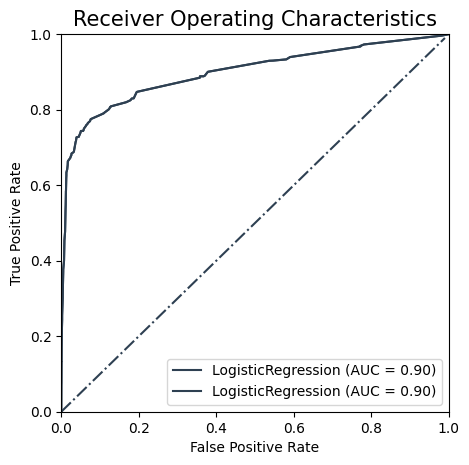

In [273]:
print("Logistic Regression:", evaluate(model, X_val, Y_val))
roc_plot(model, X_val, Y_val)

Naive Bayes: 0.888909542088139


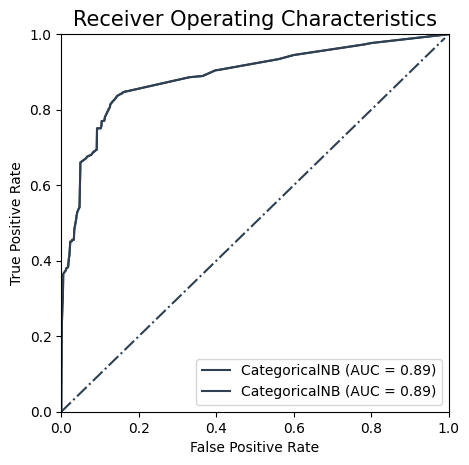

In [242]:
print("Naive Bayes:", evaluate(cnb, X_val, Y_val))
roc_plot(cnb, X_val, Y_val)


In [275]:
print("KNN:", evaluate(knn, X_val, Y_val))

KNN: 0.8621077256417132


# Evaluate Model

In this section, we will evaluate our model's performance on the validation dataset. 

Here are the list of questions to think about while deciding how to evaluate your model - 
*   Is accuracy the right metric to evaluate the model? Are inaccuracies correctly penalized in the accuracy metric?
*  Would you think that the cost of false negative is more than the false positive? Is it dependent on the application?
*  Which metric will minimize false negatives and false positives?
*   Which dataset should you chose to evaluate the model? Validation or Test?
What other metric is relevant in our context?  

For benchmarking everyone’s results we will stick to ROC AUC score as a metric. 
There are standard functions to compute these scores in `sklearn`, so we will use them. 
Specifically, we will be using [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) and [`plot_roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html).


# Hyperparameter Search

In this section we will be searching for the best parameters to build our models. 
This is where we will use our validation dataset. 




Hyperparameter search can become messy if you have lots of paramters. 
A brute force method to do such a search will be to do a grid search to fit tons of models. 
Thus, a smarter way to do hyperparameter search has been the subject of research. 

**TRY:** If interested, read [here](https://scikit-learn.org/stable/modules/grid_search.html) for more details and incorporate some of those ideas in the model building process. 

In [247]:
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20)}
]

# Create grid search object

clf = GridSearchCV(model, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_lr = clf.fit(X_train, y_train)
best.lr.predict(X_val)

TypeError: ignored

# Report your results

**NOTE:** You should use the test dataset only when you are done with hyperparameter search on your model. 
This is because the test dataset is not involved in the model building process, thereby making sure that the performance evaluation on the test dataset measures how well the proposed model is able to generalize.

In [ ]:
X_test, Y_test = preprocess(test_data, encoder, lb)
auc_score = evaluate(best_model, X_test, Y_test)
print(f"AUC-ROC on the test dataset:{auc_score}")


AUC-ROC on the test dataset:0.8114507841261618


Is this the end?

What do you need to do to make the model practically applicable? How would you use this model in the real life?

# Collaborate with Ensemble 

You can combine various models to form an ensemble model. 
There are various ways to combine these models. 
All of them serve a particular purpose (e.g. reducing variance, increasing accuracy. etc.). 

The simplest example of an ensemble is to combine the constituent models via voting. This can be done in two ways:
*  soft voting - likelihood of the input belonging to a class is the mean of the likelihood predicted by the constituent models, 
*  hard-voting - likelihood of the input belonging to a class is determined by frequency of the constutuent models predicting that class for the input.

Thus, if you are working in a team, let each member try out different models. At the end, combine your models and make an ensemble model. 

Here is the [User Guide](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) and [API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) for making such an ensemble model.

# Extras: Class imbalance

**TRY:** 
 Why not try resampling techniques to optimize for ROC AUC?





# Extras: Dimensionality Reduction

**TRY:** You can try dimensionality reduction from 16 dimensions to just 2 dimensions and visualize 2D plot with just two categories - "positive" and "negative". 
To do this, try various dimension reduction techniques, for example, [LDA](https://scikit-learn.org/stable/modules/lda_qda.html#mathematical-formulation-of-lda-dimensionality-reduction), [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 


# Poster template 

It is often the most difficult task to communicate the project's finding concisely in 1 minute or in a 1 slide. 
Therefore, our suggestion will be to touch upon the following points in your poster -  

1. Briefly define the problem
2. Briefly describe the dataset 
3. What did you learn about various models/techniques/etc.? e.g. 
4. What's the auc score of your final model did you get?

If you want to learn what matters in building such posters, check out this great [YouTube video](https://www.youtube.com/watch?v=1RwJbhkCA58).
Specifically, we should try and avoid posters with a lot of stuff to avoid cognitive overload. 
The templates suggested in the video can be found [here](https://osf.io/ef53g/). 
Note these are for academic papers, however, you can follow a similar ideology to concizsely display your work. 